In [1]:
import gzip
from collections import defaultdict
from sklearn import linear_model
import csv
import random
import matplotlib
import matplotlib.pyplot as plt
from functools import lru_cache
import numpy as np
import pandas as pd
import sys
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt

SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

In [4]:
def readCSV(path):
    f = gzip.open(path, 'rt')
    c = csv.reader(f)
    header = next(c)
    for l in c:
        d = dict(zip(header,l))
        yield d

## Data Filtering

In [5]:
data_=[]
for d in readCSV("subscribers_count.csv.gz"):
    data_.append(d)

In [6]:
sub_count={}
for d in data_:
    sub_count[d['subreddit']]=int(d['subscribers'])
    
avSub=sum(sub_count.values())/len(sub_count)

In [7]:
avSub

63740.865577889446

In [8]:
data=[]
for d in readCSV("redditSubmissions.csv.gz"):
    data.append(d)

In [9]:
df=pd.DataFrame(data)

In [10]:
#Original Data
df

,#image_id,unixtime,rawtime,title,total_votes,reddit_id,number_of_upvotes,subreddit,number_of_downvotes,localtime,score,number_of_comments,username
0,0,1333172439,2012-03-31T12:40:39.590113-07:00,And here's a downvote.,63470,rmqjs,32657,funny,30813,1333197639,1844,622,Animates_Everything
1,0,1333178161,2012-03-31T14:16:01.093638-07:00,Expectation,35,rmun4,29,GifSound,6,1333203361,23,3,Gangsta_Raper
2,0,1333199913,2012-03-31T20:18:33.192906-07:00,Downvote,41,rna86,32,GifSound,9,1333225113,23,0,Gangsta_Raper
3,0,1333252330,2012-04-01T10:52:10-07:00,Every time I downvote something,10,ro7e4,6,GifSound,4,1333277530,2,0,Gangsta_Raper
4,0,1333272954,2012-04-01T16:35:54.393381-07:00,Downvote &quot;Dies Irae&quot;,65,rooof,57,GifSound,8,1333298154,49,0,Gangsta_Raper
...,...,...,...,...,...,...,...,...,...,...,...,...,...
132303,9998,1344759846,2012-08-12T15:24:06-07:00,OM NOM NOM,34,y41wv,25,funny,9,1344785046,16,0,vaggietales
132304,9998,1345270178,2012-08-18T13:09:38-07:00,Don't feed the animals...,19,yfw66,14,funny,5,1345295378,9,2,Deydria
132305,9998,1345953962,2012-08-26T04:06:02+00:00,WTF worthy.,49,yu838,26,WTF,23,1345953962,3,6,beatlesrock
132306,9998,1346625906,2012-09-02T22:45:06+00:00,"Just a camel eating a kids head, welcome to th...",123,z91ah,65,WTF,58,1346625906,7,12,v7o


In [11]:
data[0]

{'#image_id': '0',
 'unixtime': '1333172439',
 'rawtime': '2012-03-31T12:40:39.590113-07:00',
 'title': "And here's a downvote.",
 'total_votes': '63470',
 'reddit_id': 'rmqjs',
 'number_of_upvotes': '32657',
 'subreddit': 'funny',
 'number_of_downvotes': '30813',
 'localtime': '1333197639',
 'score': '1844',
 'number_of_comments': '622',
 'username': 'Animates_Everything'}

In [12]:
# Making Data Batter

# Removing some random useless entry
del data[53033]

# Value Typecasting
max_title_len=0
max_subscribers=0
max_unix_time=0
min_unix_time=float('inf')

for d in data:
    d['unixtime']=int(d['unixtime'])
    d['total_votes']=int(d['total_votes'])
    d['number_of_upvotes']=int(d['number_of_upvotes'])
    d['number_of_downvotes']=int(d['number_of_downvotes'])
    d['localtime']=int(d['localtime'])
    d['score']=int(d['score'])
    d['number_of_comments']=max(int(d['number_of_comments']),0)
    
    max_unix_time=max(max_unix_time, d['unixtime'])
    min_unix_time = min(min_unix_time, d['unixtime'])
    
# Adding some nice features
for d in data:
    if int(d['total_votes'])==0:
        d['score_norm']=0
    else:
        d['score_norm']=float(d['number_of_upvotes']/d['total_votes'])
        
    d['title_len']=len(d['title'])
    max_title_len=max(max_title_len,d['title_len'])

for d in data:
    dt_object=datetime.fromtimestamp(d['unixtime'])
    d['weekday']=int(dt_object.weekday())
    d['timeOfDay']=int(dt_object.time().hour)
    
    sub=d['subreddit']
    subscribe=avSub
    if sub in sub_count:
        subscribe = sub_count[sub]
    
    d['subscribers']=subscribe
    max_subscribers=max(max_subscribers,d['subscribers'])
    
    
def filter(row):
    return row['total_votes'] >= 10

data = [d for d in data if filter(d)]

In [13]:
df_=pd.DataFrame(data)

In [14]:
df_.describe()

,unixtime,total_votes,number_of_upvotes,number_of_downvotes,localtime,score,number_of_comments,score_norm,title_len,weekday,timeOfDay,subscribers
count,1.157090e+05,115709.000000,115709.000000,115709.000000,1.157090e+05,115709.000000,115709.000000,115709.000000,115709.000000,115709.000000,115709.000000,1.157090e+05
mean,1.338951e+09,2152.534211,1209.516943,943.017267,1.338970e+09,266.499676,44.593835,0.636773,35.373273,2.955933,11.708960,2.017486e+06
std,1.333118e+07,6339.113842,3374.706731,2971.773873,1.332541e+07,505.773311,151.833657,0.150304,24.465102,2.019494,7.201332,9.506106e+05
min,1.217219e+09,10.000000,0.000000,0.000000,1.217244e+09,-264.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000e+00
25%,1.331826e+09,22.000000,13.000000,8.000000,1.331852e+09,5.000000,0.000000,0.548334,18.000000,1.000000,5.000000,1.520137e+06
50%,1.343269e+09,66.000000,45.000000,19.000000,1.343294e+09,25.000000,4.000000,0.639021,30.000000,3.000000,12.000000,2.601566e+06
75%,1.348555e+09,582.000000,426.000000,155.000000,1.348562e+09,253.000000,20.000000,0.744538,46.000000,5.000000,18.000000,2.665613e+06
max,1.359095e+09,177103.000000,90396.000000,86707.000000,1.359095e+09,20570.000000,8357.000000,1.000000,313.000000,6.000000,23.000000,2.665613e+06


In [15]:
data[0]

{'#image_id': '0',
 'unixtime': 1333172439,
 'rawtime': '2012-03-31T12:40:39.590113-07:00',
 'title': "And here's a downvote.",
 'total_votes': 63470,
 'reddit_id': 'rmqjs',
 'number_of_upvotes': 32657,
 'subreddit': 'funny',
 'number_of_downvotes': 30813,
 'localtime': 1333197639,
 'score': 1844,
 'number_of_comments': 622,
 'username': 'Animates_Everything',
 'score_norm': 0.5145265479754214,
 'title_len': 22,
 'weekday': 4,
 'timeOfDay': 22,
 'subscribers': 2665613}

In [15]:
# Creating 1-Hot Encoder object and removing redundant first dimension

# Hot-encoding the day of week

wd=set()
td=set()

for d in data:
    wd.add(d['weekday'])
    td.add(d['timeOfDay'])

y=[[t] for t in wd]
z=[[t] for t in td]
    
enc1 = OneHotEncoder(drop='first')
print("One Hot Encoding for day of week (after removing first dimension)")
print(enc1.fit(y).transform(y).toarray())

# Hot-encoding the time of day
enc2 = OneHotEncoder(drop='first')
print("\nOne Hot Encoding for time of day (after removing first dimension)")
print(enc2.fit(z).transform(z).toarray())

One Hot Encoding for day of week (after removing first dimension)
[[0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]

One Hot Encoding for time of day (after removing first dimension)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

## Data Exploration

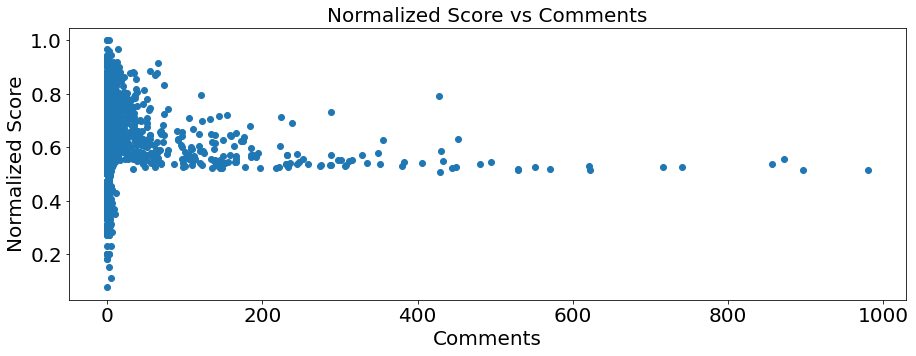

In [17]:
# Normalized Score vs Time

Y=[]
X=[]

for d in data:
    # Ignoring outliers for comment count
    if d['number_of_comments']<1000:
        Y.append(d['score_norm'])
        X.append(d['number_of_comments'])

plt.figure(figsize=(15,5))
plt.scatter(X[::100],Y[::100])
plt.ylabel("Normalized Score")
plt.xlabel("Comments")
plt.title("Normalized Score vs Comments")
plt.show()

Text(0.5, 1.0, 'Average Normalized Score vs Comments')

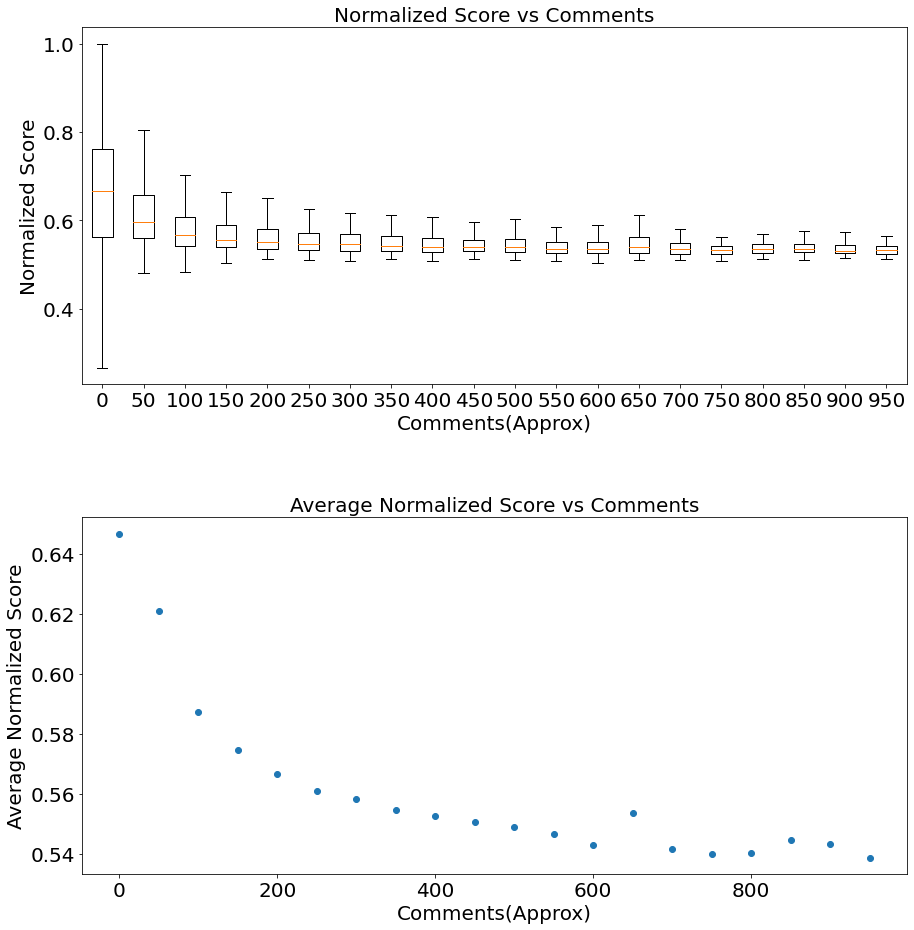

In [18]:
# Av Normalzied Score vs Time of the day
H={}
for d in data:
    if d['number_of_comments']<1000:
        
        #Seperating commments into bins of 50
        comments=(d['number_of_comments']//50)*50
        if comments not in H:
            H[comments]=[]
        H[comments].append(d['score_norm'])

D={}
for m in H:
    D[m]=sum(H[m])/len(H[m])
    
H={k: v for k, v in sorted(H.items(), key=lambda item: item[0])}
D={k: v for k, v in sorted(D.items(), key=lambda item: item[0])}

fig, ax = plt.subplots(2,1,figsize=(15,15))
fig.tight_layout(pad=5.0)
ax[0].boxplot(H.values(),showfliers=False)
ax[0].set_xticklabels(H.keys())
ax[0].set_title("Normalized Score vs Comments")   
ax[0].set_ylabel("Normalized Score")
ax[0].set_xlabel("Comments(Approx)")

ax[1].scatter(D.keys(),D.values())
ax[1].set_ylabel("Average Normalized Score")
ax[1].set_xlabel("Comments(Approx)")
ax[1].set_title("Average Normalized Score vs Comments")

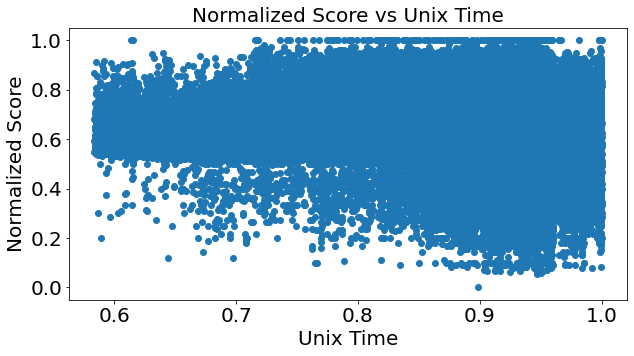

[[-0.16429828]] [0.7780567]


In [19]:
# Normalzied Score vs Time

Y=[]
X=[]
max_time = max(d['unixtime'] for d in data)
min_time = min(d['unixtime'] for d in data)

for d in data:
     # Ignoring outliers for time
    if d['unixtime']>1.3*1e9:
        Y.append(d['score_norm'])
        X.append((d['unixtime'] - min_time)/(max_time - min_time))

plt.figure(figsize=(10,5))
plt.scatter(X,Y)
plt.ylabel("Normalized Score")
plt.xlabel("Unix Time")
plt.title("Normalized Score vs Unix Time")
plt.show()

lr = LinearRegression()
lr.fit([[x] for x in X], [[y] for y in Y])
print(lr.coef_, lr.intercept_)

<ipython-input-20-69e8a534fee4>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(days_)


[Text(-1.0, 0, ' '),
 Text(0.0, 0, 'Mon'),
 Text(1.0, 0, 'Tue'),
 Text(2.0, 0, 'Wed'),
 Text(3.0, 0, 'Thu'),
 Text(4.0, 0, 'Fri'),
 Text(5.0, 0, 'Sat'),
 Text(6.0, 0, 'Sun'),
 Text(7.0, 0, '')]

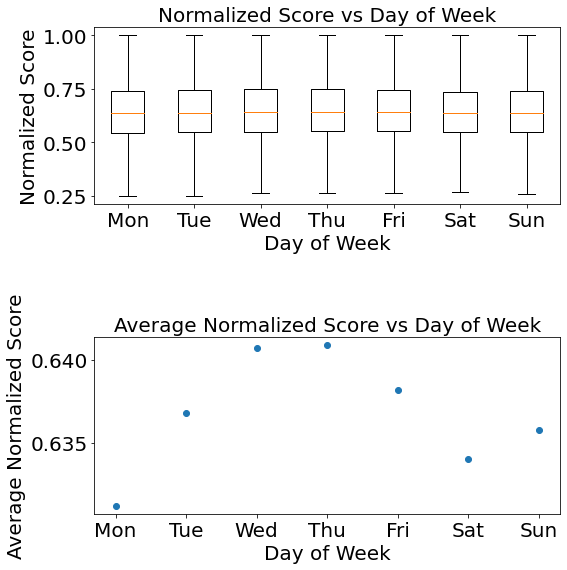

In [20]:
# Average Normalized Score vs WeekDay
days=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

M={}
for d in data:
    if d['weekday'] not in M:
        M[d['weekday']]=[]
    M[d['weekday']].append(d['score_norm'])
       
D={}
for m in M:
    D[m]=sum(M[m])/len(M[m])
    
M={k: v for k, v in sorted(M.items(), key=lambda item: item[0])}
D={k: v for k, v in sorted(D.items(), key=lambda item: item[0])}

fig, ax = plt.subplots(2,1,figsize=(10,10))
fig.tight_layout(pad=5.0)
ax[0].boxplot(M.values(),showfliers=False)
ax[0].set_xticklabels(days)
ax[0].set_ylabel("Normalized Score")
ax[0].set_xlabel("Day of Week")   
ax[0].set_title('Normalized Score vs Day of Week')    
 
days_=days   
days_.insert(0," ")    
ax[1].scatter(D.keys(),D.values())
ax[1].set_ylabel("Average Normalized Score")
ax[1].set_xlabel("Day of Week")
ax[1].set_title('Average Normalized Score vs Day of Week')
ax[1].set_xticklabels(days_)

In [21]:
D.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6])

Text(0.5, 1.0, 'Average Normalized Score vs Time of Day')

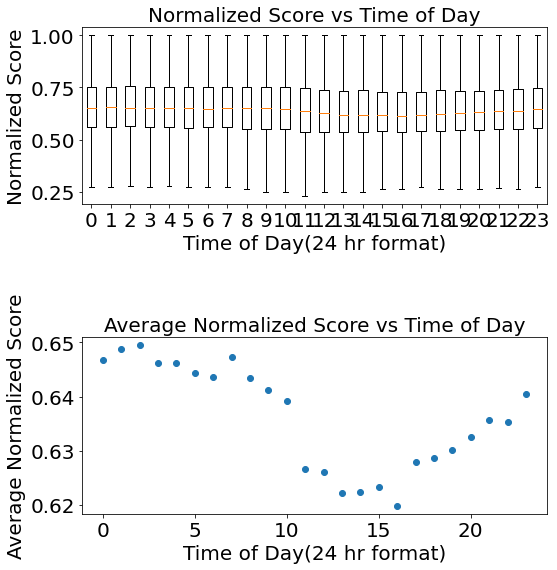

In [22]:
# Av Normalzied Score vs Time of the day
H={}
for d in data:
    if d['timeOfDay'] not in H:
        H[d['timeOfDay']]=[]
    H[d['timeOfDay']].append(d['score_norm'])

D={}
for m in H:
    D[m]=sum(H[m])/len(H[m])
    
H={k: v for k, v in sorted(H.items(), key=lambda item: item[0])}
D={k: v for k, v in sorted(D.items(), key=lambda item: item[0])}

fig, ax = plt.subplots(2,1,figsize=(10,10))
fig.tight_layout(pad=5.0)
ax[0].boxplot(H.values(),showfliers=False)
ax[0].set_xticklabels(H.keys())
ax[0].set_ylabel("Normalized Score")
ax[0].set_xlabel("Time of Day(24 hr format)")
ax[0].set_title("Normalized Score vs Time of Day")

ax[1].scatter(D.keys(),D.values())   
ax[1].set_ylabel("Average Normalized Score")
ax[1].set_xlabel("Time of Day(24 hr format)")
ax[1].set_title("Average Normalized Score vs Time of Day")

Text(0.5, 1.0, 'Average Normalized Score vs Title Length')

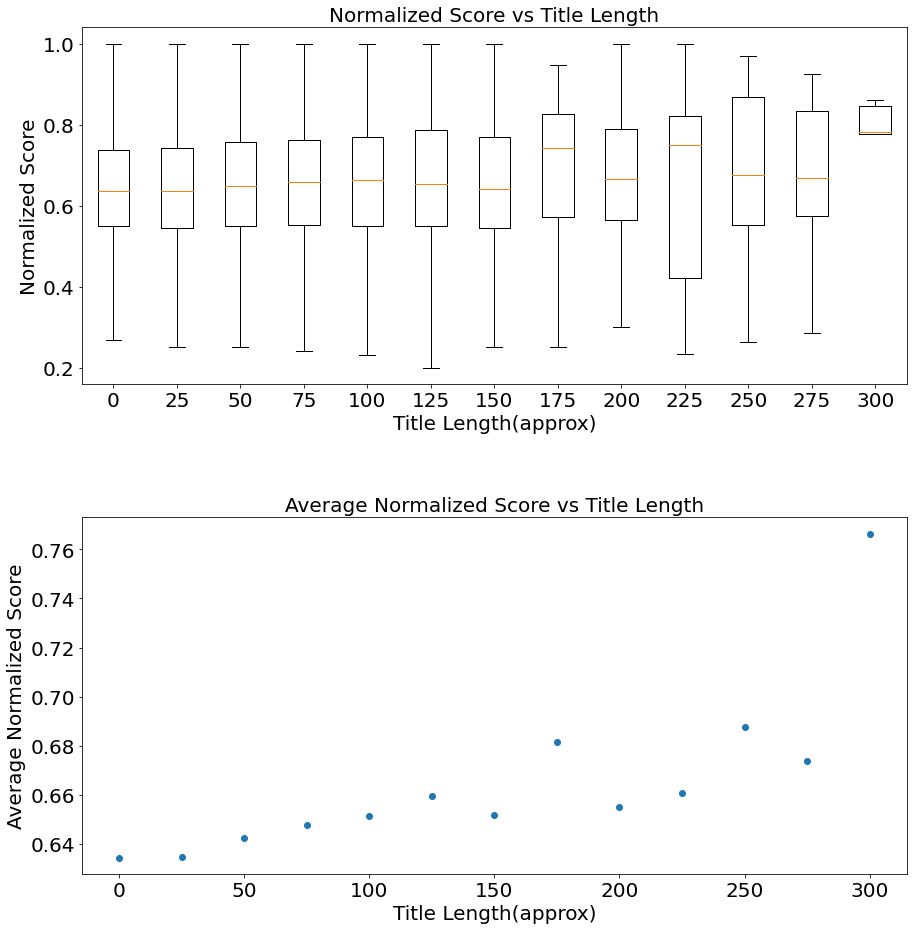

In [23]:
# Av Normalzied Score vs Time of the day
H={}
for d in data:
    
    # Dividing title length into bins of 25
    len_=(d['title_len']//25)*25
    if len_ not in H:
        H[len_]=[]
    H[len_].append(d['score_norm'])

D={}
for m in H:
    D[m]=sum(H[m])/len(H[m])
    
H={k: v for k, v in sorted(H.items(), key=lambda item: item[0])}
D={k: v for k, v in sorted(D.items(), key=lambda item: item[0])}

fig, ax = plt.subplots(2,1,figsize=(15,15))
fig.tight_layout(pad=5.0)
ax[0].boxplot(H.values(),showfliers=False)
ax[0].set_xticklabels(H.keys())   
ax[0].set_ylabel("Normalized Score")
ax[0].set_xlabel("Title Length(approx)")
ax[0].set_title("Normalized Score vs Title Length")   
    
ax[1].scatter(D.keys(),D.values())    
ax[1].set_ylabel("Average Normalized Score")
ax[1].set_xlabel("Title Length(approx)")
ax[1].set_title("Average Normalized Score vs Title Length")  

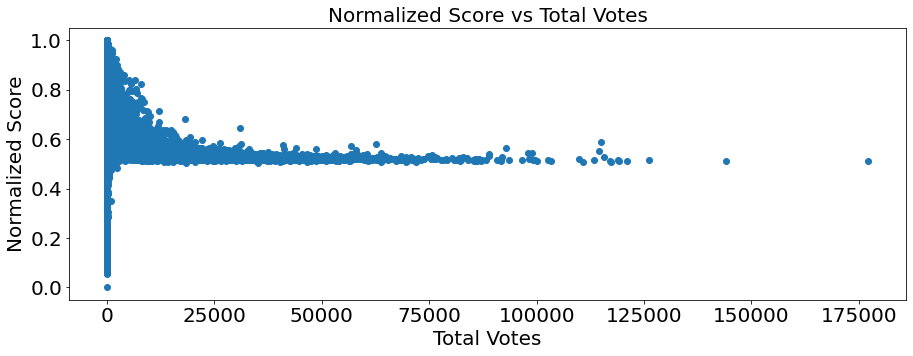

In [24]:
# Normalzied Score vs Total votes

Y=[]
X=[]

for d in data:
    Y.append(d['score_norm'])
    X.append(d['total_votes'])

plt.figure(figsize=(15,5))
plt.scatter(X,Y)
plt.ylabel("Normalized Score")
plt.xlabel("Total Votes")
plt.title("Normalized Score vs Total Votes")
plt.show()

Text(0.5, 1.0, 'Average Normalized Score vs Total Votes')

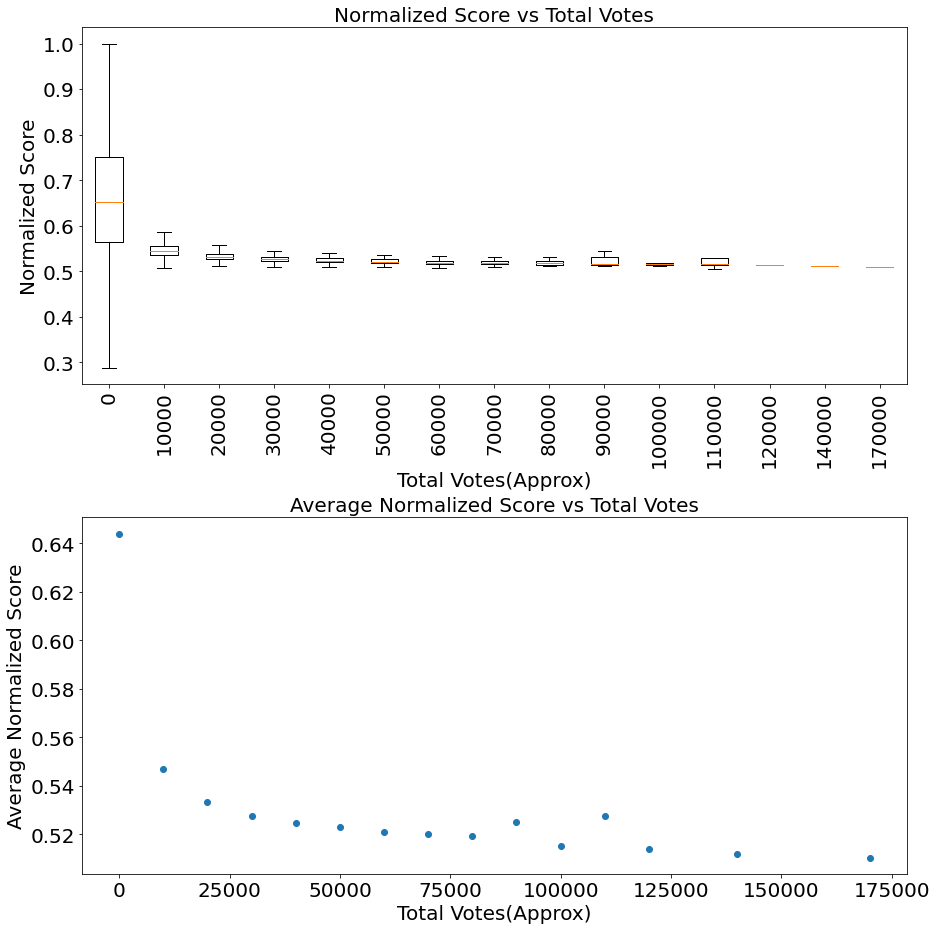

In [25]:
# Av Normalzied Score vs Total Votes
H={}
for d in data:

    #Seperating total votes into bins of 10000
    votes=(d['total_votes']//10000)*10000
    if votes not in H:
        H[votes]=[]
    H[votes].append(d['score_norm'])

D={}
for m in H:
    D[m]=sum(H[m])/len(H[m])
    
H={k: v for k, v in sorted(H.items(), key=lambda item: item[0])}
D={k: v for k, v in sorted(D.items(), key=lambda item: item[0])}

fig, ax = plt.subplots(2,1,figsize=(15,15))
fig.tight_layout(pad=5.0)
ax[0].boxplot(H.values(),showfliers=False)
ax[0].set_xticklabels(H.keys(), rotation='vertical')
ax[0].set_ylabel("Normalized Score")
ax[0].set_xlabel("Total Votes(Approx)")   
ax[0].set_title("Normalized Score vs Total Votes")   

ax[1].scatter(D.keys(),D.values())
ax[1].set_ylabel("Average Normalized Score")
ax[1].set_xlabel("Total Votes(Approx)")
ax[1].set_title("Average Normalized Score vs Total Votes") 

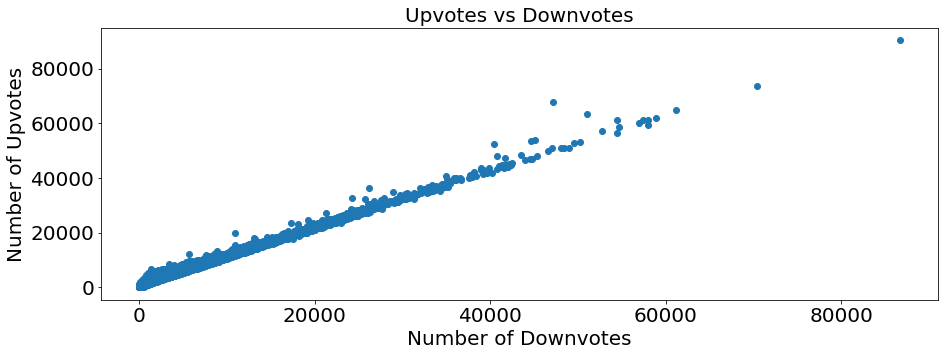

In [26]:
# Upvotes vs Downvotes

Y=[]
X=[]

for d in data:
    Y.append(d['number_of_upvotes'])
    X.append(d['number_of_downvotes'])

plt.figure(figsize=(15,5))
plt.scatter(X,Y)
plt.ylabel("Number of Upvotes")
plt.xlabel("Number of Downvotes")
plt.title("Upvotes vs Downvotes")
plt.show()

Text(0.5, 1.0, 'Average Normalized Score vs Subscriber Count')

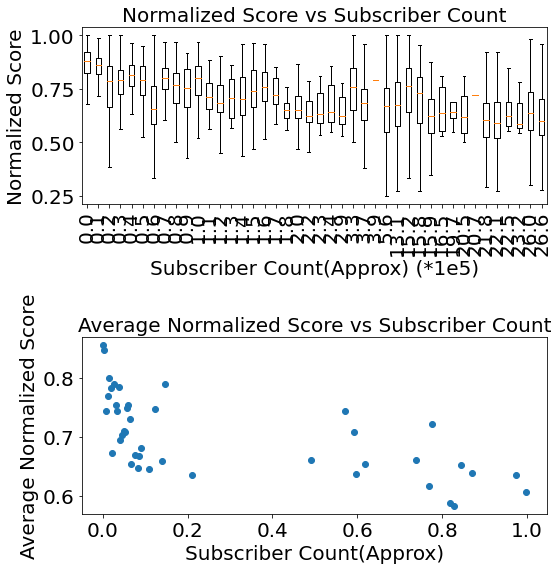

In [27]:
# Av Normalzied Score vs Subscribers
H={}
for d in data:
    
    sub=d['subreddit']
    subscribe=avSub
    if sub in sub_count:
        subscribe = sub_count[sub]
    
    #Seperating subscribers into bins of 100000
        
    subscribe=(subscribe//10000)*10000
    
    if subscribe not in H:
        H[subscribe]=[]
    H[subscribe].append(d['score_norm'])

D={}
for m in H:
    D[m]=sum(H[m])/len(H[m])

max_subscribers = max(sub_count.values())
    
H={k: v for k, v in sorted(H.items(), key=lambda item: item[0])}
D={k/max_subscribers: v for k, v in sorted(D.items(), key=lambda item: item[0])}

fig, ax = plt.subplots(2,1,figsize=(10,10))
fig.tight_layout(pad=5.0)
lab=np.array(list(H.keys()))
lab=lab/100000
ax[0].boxplot(H.values(),showfliers=False)
ax[0].set_xticklabels(lab, rotation='vertical')
ax[0].set_ylabel("Normalized Score")
ax[0].set_xlabel("Subscriber Count(Approx) (*1e5)")
ax[0].set_title("Normalized Score vs Subscriber Count")

ax[1].scatter(D.keys(),D.values())
ax[1].set_ylabel("Average Normalized Score")
ax[1].set_xlabel("Subscriber Count(Approx)")
ax[1].set_title("Average Normalized Score vs Subscriber Count")

## Model Training

In [16]:
def MSE(y,ypred):
    y=np.array(y)
    ypred=np.array(ypred)
    return round(np.sum(np.square(y-ypred))/len(y-ypred),5)

def MAE(y, ypred):
    y=np.array(y)
    ypred=np.array(ypred)
    return round(np.sum(np.abs(y-ypred))/len(y-ypred),5)    

In [17]:
data[0:2]

[{'#image_id': '0',
  'unixtime': 1333172439,
  'rawtime': '2012-03-31T12:40:39.590113-07:00',
  'title': "And here's a downvote.",
  'total_votes': 63470,
  'reddit_id': 'rmqjs',
  'number_of_upvotes': 32657,
  'subreddit': 'funny',
  'number_of_downvotes': 30813,
  'localtime': 1333197639,
  'score': 1844,
  'number_of_comments': 622,
  'username': 'Animates_Everything',
  'score_norm': 0.5145265479754214,
  'title_len': 22,
  'weekday': 4,
  'timeOfDay': 22,
  'subscribers': 2665613},
 {'#image_id': '0',
  'unixtime': 1333178161,
  'rawtime': '2012-03-31T14:16:01.093638-07:00',
  'title': 'Expectation',
  'total_votes': 35,
  'reddit_id': 'rmun4',
  'number_of_upvotes': 29,
  'subreddit': 'GifSound',
  'number_of_downvotes': 6,
  'localtime': 1333203361,
  'score': 23,
  'number_of_comments': 3,
  'username': 'Gangsta_Raper',
  'score_norm': 0.8285714285714286,
  'title_len': 11,
  'weekday': 5,
  'timeOfDay': 0,
  'subscribers': 20648}]

In [18]:
L=len(data)
data.sort(key=lambda x: x['unixtime'])

In [19]:
train=data[:int(0.8*L)]
val=data[int(0.8*L):int(0.9*L)]
test=data[int(0.9*L):]

In [20]:
count_s=defaultdict()
count_u=defaultdict()
count_i=defaultdict()
max_u=0
max_i=0
max_s=0

for d in data:
    sub=d['subreddit']
    user=d['username']
    image=d['#image_id']    
    
    if sub not in count_s:
        count_s[sub]=0
    
    if user not in count_u:
        count_u[user]=0
        
    if image not in count_i:
        count_i[image]=0
    
    count_s[sub]+=1
    count_i[image]+=1
    count_u[user]+=1

    max_u=max(max_u,count_u[user])
    max_i=max(max_i,count_i[image])
    max_s=max(max_s,count_s[sub])

In [21]:
avScore=0
for d  in train:
    avScore+=d['score_norm']
    
avScore/=len(train)    

scorePerImageTime=defaultdict(list)
scorePerUserTime=defaultdict(list)

prev_im=defaultdict(list)
prev_us=defaultdict(list)

for d in train:
    image=d['#image_id']
    user=d['username']
    time=d['unixtime']
    
    if len(prev_im[image])>0:
        scorePerImageTime[(image,time)]=np.mean(prev_im[image])
        
    prev_im[image].append(d['score_norm'])
    
    if len(prev_us[user])>0:
        scorePerUserTime[(user,time)]=np.mean(prev_us[user])
        
    prev_us[user].append(d['score_norm'])   

In [22]:
avScore

0.6468872295806947

### Baseline 1: Provide average normalized score of whole train data as predictions 

In [24]:
labels_train=[]
for d in train:
    labels_train.append(d['score_norm'])
    
preds_train=[avScore]*len(train)
print("Train MSE: ", MSE(labels_train, preds_train))
print("Train MAE: ", MAE(labels_train, preds_train))

Train MSE:  0.02015
Train MAE:  0.11184


In [25]:
labels_val=[]
for d in val:
    labels_val.append(d['score_norm'])
    
preds_val=[avScore]*len(val)
print("Validation MSE: ", MSE(labels_val, preds_val))
print("Validation MAE: ", MAE(labels_val, preds_val))

Validation MSE:  0.0333
Validation MAE:  0.14724


In [26]:
labels_test=[]
for d in test:
    labels_test.append(d['score_norm'])
    
preds_test=[avScore]*len(test)
print("Test MSE: ", MSE(labels_test, preds_test))
print("Test MAE: ", MAE(labels_test, preds_test))

Test MSE:  0.03244
Test MAE:  0.14346


### Baseline 2: Provide average normalized score for query image and for cold start, of whole train data

In [27]:
labels_train=[]
preds_train=[]
for d in train:
    image=d['#image_id']
    time=d['unixtime']
    pred=avScore
    if (image,time) in scorePerImageTime:
        pred=scorePerImageTime[(image,time)]
    
    preds_train.append(pred)
    labels_train.append(d['score_norm'])

print("Train MSE: ", MSE(labels_train, preds_train))
print("Train MAE: ", MAE(labels_train, preds_train))

Train MSE:  0.01963
Train MAE:  0.10894


In [28]:
labels_val=[]
preds_val=[]
for d in val:
    image=d['#image_id']
    L=prev_im[image]
    
    labels_val.append(d['score_norm'])
    pred=avScore
    if len(L)>0:
        pred=np.mean(L)
    
    preds_val.append(pred)

print("Validation MSE: ", MSE(labels_val, preds_val))
print("Validation MAE: ", MAE(labels_val, preds_val))

Validation MSE:  0.03437
Validation MAE:  0.14642


In [29]:
labels_test=[]
preds_test=[]
for d in test:
    image=d['#image_id']
    L=prev_im[image]
    
    labels_test.append(d['score_norm'])
    pred=avScore
    if len(L)>0:
        pred=np.mean(L)
    
    preds_test.append(pred)

print("Test MSE: ", MSE(labels_test, preds_test))
print("Test MAE: ", MAE(labels_test, preds_test))

Test MSE:  0.03308
Test MAE:  0.1427


### Baseline 3: Provide average normalized score for query user and for cold start, of whole train data

In [30]:
labels_train=[]
preds_train=[]
for d in train:
    user=d['username']
    time=d['unixtime']
    pred=avScore
    
    if (user,time) in scorePerUserTime:
        pred=scorePerUserTime[(user,time)]
        
    preds_train.append(pred)
    labels_train.append(d['score_norm'])
    
print("Train MSE:", MSE(labels_train, preds_train))
print("Train MAE: ", MAE(labels_train, preds_train))

Train MSE: 0.01994
Train MAE:  0.10938


In [31]:
labels_val=[]
preds_val=[]
for d in val:
    user=d['username']
    L=prev_us[user]
    
    labels_val.append(d['score_norm'])
    pred=avScore
    if len(L)>0:
        pred=np.mean(L)
    
    preds_val.append(pred)

print("Validation MSE: ", MSE(labels_val, preds_val))
print("Validation MAE: ", MAE(labels_val, preds_val))

Validation MSE:  0.03291
Validation MAE:  0.14439


In [32]:
labels_test=[]
preds_test=[]
for d in test:
    user=d['username']
    L=prev_us[user]
    
    labels_test.append(d['score_norm'])
    pred=avScore
    if len(L)>0:
        pred=np.mean(L)
    
    preds_test.append(pred)

print("Test MSE: ", MSE(labels_test, preds_test))
print("Test MAE: ", MAE(labels_test, preds_test))

Test MSE:  0.03102
Test MAE:  0.13953


### Functions


In [36]:
def Jaccard(i1, i2):
    u1=usersPerImage[i1]
    u2=usersPerImage[i2]
    
    inter=len(u1.intersection(u2))
    den=len(u1.union(u2))
    
    if den==0:
        return 0
    
    return inter/den

def SimilarityPred(user_, image):
    users=usersPerImage[image]
    
    candidateImages=set()
    for user in users:
        for im in imagesPerUser[user]:
            candidateImages.add(im)
    
    num=0
    den=0
    for im in candidateImages:
        if im==image:
            continue
        
        sim=Jaccard(image,im)
        num+=(sim*sum(ScoresPerImage[im]) / len(ScoresPerImage[im]))
        den+=sim
        
    if den==0:
        if image in ScoresPerImage:
            return sum(ScoresPerImage[image]) / len(ScoresPerImage[image])
        else:
            return avScore
    else:
        return num/den  


### Features

In [37]:
def feata(d):
    return np.array(enc1.transform([[d['weekday']]]).toarray()).squeeze()
    
def featb(d):
    return np.array(enc2.transform([[d['timeOfDay']]]).toarray()).squeeze()     

def featc(d):
    return np.array([d['title_len']/max_title_len])

def featd(d):
    return np.array([d['subscribers']/max_subscribers])
 
def feate(d, train=False):
    user=d['username']
    time=d['unixtime']
    pred=avScore
    
    if train:
        if (user,time) in scorePerUserTime:
            pred=scorePerUserTime[(user,time)]
    else:
        L=prev_us[user]
        if len(L)>0:
            pred=sum(L) / len(L)
    
    return np.array([pred])

def featf(d, train=False):
    image=d['#image_id']
    time=d['unixtime']
    pred=avScore
    
    if train:
        if (image,time) in scorePerImageTime:
            pred=scorePerImageTime[(image,time)]
    else:
        L=prev_im[image]
        if len(L)>0:
            pred=sum(L) / len(L)
    
    return np.array([pred]) 

def featg(d):
    image=d['#image_id']
    user=d['username']
    pred=SimilarityPred(user,image)
    return [pred]

def feath(d):
    return np.array([(d['unixtime'] - min_unix_time)/(max_unix_time - min_unix_time)])

def feati(d):
    sub=d['subreddit']
    user=d['username']
    image=d['#image_id']
    
    a=0
    if sub in count_s:
        a=count_s[sub]
    
    b=0
    if user in count_u:
        b=count_u[user]
        
    c=0
    if image in count_i:
        c=count_i[image]
    
    return np.array(([a/max_s, b/max_u, c/max_i])) 

In [38]:
def feature(di, a=True, b=True, c=True, d=True, e=True, f=True, g=True, h=True, i=True, train=False):
    feat=[1]
    if a:
        feat1=feata(di)
        for x in feat1:
            feat.append(x)
        
    if b:
        feat2=featb(di)
        for x in feat2:
            feat.append(x)

    if c:
        feat3=featc(di)
        for x in feat3:
            feat.append(x)
            
    if d:
        feat4=featd(di)
        for x in feat4:
            feat.append(x)
            
    if e:
        feat5=feate(di, train)
        for x in feat5:
            feat.append(x)
            
    if f:
        feat6=featf(di, train)
        for x in feat6:
            feat.append(x)
    
    if g:
        feat7=featg(di)
        for x in feat7:
            feat.append(x)        

    if h:
        feat8=feath(di)
        for x in feat8:
            feat.append(x)  
            
    if i:
        feat9=feati(di)
        for x in feat9:
            feat.append(x)  
            
            
    return feat

### Model 1:  Linear Regression

In [39]:
count_s=defaultdict()
count_u=defaultdict()
count_i=defaultdict()

usersPerImage=defaultdict(set)
imagesPerUser=defaultdict(set)
ScoresPerImage=defaultdict(list)

X=[]
Y=[]
    
for i in tqdm(range(len(train))):
    d=train[i]
    
    sub=d['subreddit']
    user=d['username']
    image=d['#image_id']
    score=d['score_norm']
    
    if sub not in count_s:
        count_s[sub]=0
    
    if user not in count_u:
        count_u[user]=0
        
    if image not in count_i:
        count_i[image]=0
    
    count_s[sub]+=1
    count_i[image]+=1
    count_u[user]+=1

    usersPerImage[image].add(user)
    imagesPerUser[user].add(image)
    if image not in ScoresPerImage:
        ScoresPerImage[image]=[]
        
    ScoresPerImage[image].append(score)
    
    X.append(feature(d,g=False, i=False, train=True))
    Y.append(score)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92567/92567 [01:56<00:00, 797.20it/s]


In [40]:
mod = linear_model.LinearRegression(fit_intercept=False)
mod.fit(X,Y)
mod.coef_

array([ 2.73001233e-01,  3.88644598e-03,  5.11059889e-03,  5.57716803e-03,
        3.59823813e-03, -8.68009010e-04, -3.22191045e-04,  8.94476531e-04,
        2.11190561e-03, -8.82312231e-04,  1.28829560e-03,  5.96636054e-04,
       -3.21552669e-04,  6.63268765e-03,  1.51050438e-03,  3.59239791e-05,
       -5.72438524e-04, -6.41044025e-03, -1.16442846e-02, -2.04912679e-02,
       -2.22134398e-02, -2.19934869e-02, -2.47618608e-02, -2.06508184e-02,
       -1.76219507e-02, -1.76099295e-02, -1.57821630e-02, -1.32203198e-02,
       -1.14376424e-02, -8.32573795e-03,  4.48455381e-02, -7.52607134e-02,
        3.40954932e-01,  4.64037177e-01, -1.11788344e-01])

In [41]:
Y_pred=mod.predict(X)
print("Training MSE: ", MSE(Y, Y_pred))
print("Training MAE: ", MAE(Y, Y_pred))

Training MSE:  0.01664
Training MAE:  0.10046


In [42]:
X=[]
Y=[]

for i in tqdm(range(len(val))):
    d=val[i]
    X.append(feature(d, g=False, i=False))
    score=d['score_norm']
    Y.append(score)

Y_pred=mod.predict(X)    
print("Validation MSE: ", MSE(Y, Y_pred))
print("Validation MAE: ", MAE(Y, Y_pred))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11571/11571 [00:09<00:00, 1197.15it/s]

Validation MSE:  0.02893
Validation MAE:  0.13541


In [43]:
X=[]
Y=[]

for i in tqdm(range(len(test))):
    d=test[i]
    X.append(feature(d, g=False, i=False))
    score=d['score_norm']
    Y.append(score)
    

Y_pred=mod.predict(X)     
print("Test MSE: ", MSE(Y, Y_pred))
print("Test MAE: ", MAE(Y, Y_pred))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11571/11571 [00:09<00:00, 1215.33it/s]

Test MSE:  0.02717
Test MAE:  0.13073


### Model 2: Weighted Jaccard Similarity +  Linear Regression

In [44]:
count_s=defaultdict()
count_u=defaultdict()
count_i=defaultdict()

usersPerImage=defaultdict(set)
imagesPerUser=defaultdict(set)
ScoresPerImage=defaultdict(list)

X=[]
Y=[]
    
for i in tqdm(range(len(train))):
    d=train[i]
    
    sub=d['subreddit']
    user=d['username']
    image=d['#image_id']
    score=d['score_norm']
    
    if sub not in count_s:
        count_s[sub]=0
    
    if user not in count_u:
        count_u[user]=0
        
    if image not in count_i:
        count_i[image]=0
    
    count_s[sub]+=1
    count_i[image]+=1
    count_u[user]+=1

    usersPerImage[image].add(user)
    imagesPerUser[user].add(image)
    if image not in ScoresPerImage:
        ScoresPerImage[image]=[]
        
    ScoresPerImage[image].append(score)
    
    X.append(feature(d,train=True))
    Y.append(score)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92567/92567 [13:49<00:00, 111.55it/s]


In [45]:
mod = linear_model.LinearRegression(fit_intercept=False)
mod.fit(X,Y)
mod.coef_

array([-1.86409552e-02,  3.90262094e-03,  4.86724500e-03,  5.23662094e-03,
        3.63953860e-03, -6.11281595e-04, -5.31597433e-05,  4.02085537e-04,
        1.68983516e-03, -6.73041237e-04,  1.19191169e-03, -6.14403222e-04,
        3.83954614e-04,  5.86144904e-03,  2.00466898e-03,  1.46054489e-03,
        1.52716691e-03, -4.08501378e-03, -9.10748758e-03, -1.70982661e-02,
       -1.76683490e-02, -1.88762426e-02, -2.21306980e-02, -1.90969710e-02,
       -1.52490229e-02, -1.52334098e-02, -1.39498660e-02, -1.18150175e-02,
       -1.03998992e-02, -7.01219165e-03,  4.76066498e-02, -5.39319999e-02,
        1.70303862e-01,  3.50547426e-01,  5.93914795e-01,  4.22425901e-03,
       -5.47817406e-02, -1.56817360e-01, -1.63217713e-01])

In [46]:
Y_pred=mod.predict(X)
print("Training MSE: ", MSE(Y, Y_pred))
print("Training MAE: ", MAE(Y, Y_pred))

Training MSE:  0.01515
Training MAE:  0.09391


In [47]:
X=[]
Y=[]

for i in tqdm(range(len(val))):
    d=val[i]
    X.append(feature(d))
    score=d['score_norm']
    Y.append(score)

Y_pred=mod.predict(X)    
print("Validation MSE: ", MSE(Y, Y_pred))
print("Validation MAE: ", MAE(Y, Y_pred))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11571/11571 [02:11<00:00, 88.28it/s]

Validation MSE:  0.02831
Validation MAE:  0.13383


In [48]:
X=[]
Y=[]

for i in tqdm(range(len(test))):
    d=test[i]
    X.append(feature(d))
    score=d['score_norm']
    Y.append(score)

Y_pred=mod.predict(X)     
print("Test MSE: ", MSE(Y, Y_pred))
print("Test MAE: ", MAE(Y, Y_pred))

 24%|██████████████████████████████████████▏                                                                                                                           | 2727/11571 [00:28<01:33, 94.23it/s]


KeyboardInterrupt: 

### Model 3: Ridge Regression

In [53]:
count_s=defaultdict()
count_u=defaultdict()
count_i=defaultdict()

usersPerImage=defaultdict(set)
imagesPerUser=defaultdict(set)
ScoresPerImage=defaultdict(list)

X_train=[]
Y_train=[]
    
for i in tqdm(range(len(train))):
    d=train[i]
    
    sub=d['subreddit']
    user=d['username']
    image=d['#image_id']
    score=d['score_norm']
    
    if sub not in count_s:
        count_s[sub]=0
    
    if user not in count_u:
        count_u[user]=0
        
    if image not in count_i:
        count_i[image]=0
    
    count_s[sub]+=1
    count_i[image]+=1
    count_u[user]+=1

    usersPerImage[image].add(user)
    imagesPerUser[user].add(image)
    if image not in ScoresPerImage:
        ScoresPerImage[image]=[]
        
    ScoresPerImage[image].append(score)
    
    X_train.append(feature(d,train=True))
    Y_train.append(score)

X_val=[]
Y_val=[]

for i in tqdm(range(len(val))):
    d=val[i]
    X_val.append(feature(d))
    score=d['score_norm']
    Y_val.append(score)

X_test=[]
Y_test=[]

for i in tqdm(range(len(test))):
    d=test[i]
    X_test.append(feature(d))
    score=d['score_norm']
    Y_test.append(score)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11571/11571 [02:01<00:00, 95.51it/s]


In [92]:
import optuna

# 1. Define an objective function to be maximized.
def objective(trial):

    # 2. Suggest values for the hyperparameters using a trial object.
    alpha = trial.suggest_int('alpha', 1, 10000)
    
    mod = linear_model.Ridge(alpha=alpha, fit_intercept=False)
    mod.fit(X_train,Y_train)

    Y_pred=mod.predict(X_val)

    return MSE(Y_val, Y_pred)

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300)
study.best_params

[I 2021-11-30 13:18:19,663] A new study created in memory with name: no-name-c6d2d085-bf56-48ef-93f4-226c12a9b5b8
[I 2021-11-30 13:18:20,334] Trial 0 finished with value: 0.03014 and parameters: {'alpha': 9581}. Best is trial 0 with value: 0.03014.
[I 2021-11-30 13:18:21,041] Trial 1 finished with value: 0.02784 and parameters: {'alpha': 1255}. Best is trial 1 with value: 0.02784.
[I 2021-11-30 13:18:21,741] Trial 2 finished with value: 0.02785 and parameters: {'alpha': 1259}. Best is trial 1 with value: 0.02784.
[I 2021-11-30 13:18:22,439] Trial 3 finished with value: 0.02781 and parameters: {'alpha': 1129}. Best is trial 3 with value: 0.02781.
[I 2021-11-30 13:18:23,142] Trial 4 finished with value: 0.02864 and parameters: {'alpha': 3623}. Best is trial 3 with value: 0.02781.
[I 2021-11-30 13:18:23,886] Trial 5 finished with value: 0.02959 and parameters: {'alpha': 6930}. Best is trial 3 with value: 0.02781.
[I 2021-11-30 13:18:24,584] Trial 6 finished with value: 0.0301 and paramete

[I 2021-11-30 13:19:01,292] Trial 55 finished with value: 0.02792 and parameters: {'alpha': 1522}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:19:01,998] Trial 56 finished with value: 0.02827 and parameters: {'alpha': 2555}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:19:02,716] Trial 57 finished with value: 0.02772 and parameters: {'alpha': 532}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:19:03,426] Trial 58 finished with value: 0.02827 and parameters: {'alpha': 7}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:19:04,277] Trial 59 finished with value: 0.02783 and parameters: {'alpha': 1202}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:19:05,182] Trial 60 finished with value: 0.02773 and parameters: {'alpha': 437}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:19:05,870] Trial 61 finished with value: 0.02773 and parameters: {'alpha': 480}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:19:06,573] Trial 62 finished w

[I 2021-11-30 13:19:40,581] Trial 110 finished with value: 0.02789 and parameters: {'alpha': 144}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:19:41,278] Trial 111 finished with value: 0.02772 and parameters: {'alpha': 581}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:19:41,976] Trial 112 finished with value: 0.02772 and parameters: {'alpha': 523}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:19:42,678] Trial 113 finished with value: 0.02775 and parameters: {'alpha': 368}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:19:43,378] Trial 114 finished with value: 0.02775 and parameters: {'alpha': 825}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:19:44,078] Trial 115 finished with value: 0.02772 and parameters: {'alpha': 616}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:19:44,783] Trial 116 finished with value: 0.02772 and parameters: {'alpha': 531}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:19:45,498] Trial 117 fin

[I 2021-11-30 13:20:19,393] Trial 165 finished with value: 0.02774 and parameters: {'alpha': 397}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:20:20,101] Trial 166 finished with value: 0.02774 and parameters: {'alpha': 751}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:20:20,798] Trial 167 finished with value: 0.02891 and parameters: {'alpha': 4487}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:20:21,494] Trial 168 finished with value: 0.03003 and parameters: {'alpha': 8997}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:20:22,190] Trial 169 finished with value: 0.02788 and parameters: {'alpha': 1392}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:20:22,889] Trial 170 finished with value: 0.02783 and parameters: {'alpha': 203}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:20:23,666] Trial 171 finished with value: 0.02772 and parameters: {'alpha': 550}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:20:24,425] Trial 172 

[I 2021-11-30 13:21:01,215] Trial 220 finished with value: 0.02784 and parameters: {'alpha': 1229}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:21:01,922] Trial 221 finished with value: 0.02772 and parameters: {'alpha': 557}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:21:02,632] Trial 222 finished with value: 0.02773 and parameters: {'alpha': 671}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:21:03,339] Trial 223 finished with value: 0.0278 and parameters: {'alpha': 241}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:21:04,048] Trial 224 finished with value: 0.02774 and parameters: {'alpha': 755}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:21:04,757] Trial 225 finished with value: 0.02773 and parameters: {'alpha': 458}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:21:05,463] Trial 226 finished with value: 0.02775 and parameters: {'alpha': 362}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:21:06,173] Trial 227 fin

[I 2021-11-30 13:21:40,229] Trial 275 finished with value: 0.02775 and parameters: {'alpha': 831}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:21:40,936] Trial 276 finished with value: 0.02773 and parameters: {'alpha': 429}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:21:41,638] Trial 277 finished with value: 0.0278 and parameters: {'alpha': 1086}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:21:42,339] Trial 278 finished with value: 0.02773 and parameters: {'alpha': 484}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:21:43,123] Trial 279 finished with value: 0.02948 and parameters: {'alpha': 6481}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:21:43,880] Trial 280 finished with value: 0.02868 and parameters: {'alpha': 3760}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:21:44,579] Trial 281 finished with value: 0.02782 and parameters: {'alpha': 212}. Best is trial 29 with value: 0.02772.
[I 2021-11-30 13:21:45,281] Trial 282 f

{'alpha': 608}

In [93]:
mod = linear_model.Ridge(alpha=608, fit_intercept=False)
mod.fit(X_train,Y_train)

Y_pred=mod.predict(X_train)
print("Training MSE: ", MSE(Y_train, Y_pred))
print("Training MAE: ", MAE(Y_train, Y_pred))

Y_pred=mod.predict(X_val)    
print("Validation MSE: ", MSE(Y_val, Y_pred))
print("Validation MAE: ", MAE(Y_val, Y_pred))

Y_pred=mod.predict(X_test)     
print("Test MSE: ", MSE(Y_test, Y_pred))
print("Test MAE: ", MAE(Y_test, Y_pred))

mod.coef_

Training MSE:  0.01567
Training MAE:  0.09681
Validation MSE:  0.02772
Validation MAE:  0.13231
Test MSE:  0.02626
Test MAE:  0.12854


array([ 1.75546977e-01,  9.17489856e-03,  1.06880552e-02,  1.10851086e-02,
        9.13751740e-03,  4.91691074e-03,  5.34566157e-03,  1.17663587e-02,
        1.25352508e-02,  1.04455733e-02,  1.23583816e-02,  1.09371744e-02,
        1.11860418e-02,  1.63716479e-02,  1.19519515e-02,  1.11194823e-02,
        1.06462381e-02,  4.65921697e-03,  2.56704465e-04, -5.88728681e-03,
       -6.64771639e-03, -6.86061866e-03, -9.70696352e-03, -6.58524401e-03,
       -3.65195077e-03, -3.76434966e-03, -2.39895217e-03, -1.59736402e-04,
        1.12288575e-03,  4.48402982e-03,  3.26229896e-02, -4.86530281e-02,
        1.64667087e-01,  2.57421857e-01,  2.62879717e-01,  8.37024310e-02,
       -7.50690780e-02, -1.27854713e-01, -7.24770802e-02])

## Unsucessful Models

### Basic Linear Rgression

In [58]:
count_s=defaultdict()
count_u=defaultdict()
count_i=defaultdict()

usersPerImage=defaultdict(set)
imagesPerUser=defaultdict(set)
ScoresPerImage=defaultdict(list)

X=[]
Y=[]
    
for i in tqdm(range(len(train))):
    d=train[i]
    
    sub=d['subreddit']
    user=d['username']
    image=d['#image_id']
    score=d['score_norm']
    
    if sub not in count_s:
        count_s[sub]=0
    
    if user not in count_u:
        count_u[user]=0
        
    if image not in count_i:
        count_i[image]=0
    
    count_s[sub]+=1
    count_i[image]+=1
    count_u[user]+=1

    usersPerImage[image].add(user)
    imagesPerUser[user].add(image)
    if image not in ScoresPerImage:
        ScoresPerImage[image]=[]
        
    ScoresPerImage[image].append(score)
    
    X.append(feature(d,e=False, f=False, g=False, h=False, i=False, train=True))
    Y.append(score)

100%|██████████| 92567/92567 [00:30<00:00, 3076.73it/s]


In [59]:
mod = linear_model.LinearRegression()
mod.fit(X,Y)
mod.coef_

array([-1.09407255e-20,  4.72072841e-03,  6.25943283e-03,  7.23854766e-03,
        4.80498769e-03,  4.12979192e-04,  5.59504665e-04,  1.18459111e-03,
        2.14722561e-03, -4.40551815e-04,  2.24519363e-03,  8.21167658e-04,
       -6.26754972e-04,  6.00795243e-03,  2.03128286e-04, -7.77582191e-04,
       -2.21096286e-03, -1.15943028e-02, -1.65343459e-02, -2.61954089e-02,
       -2.53963208e-02, -2.34785946e-02, -2.64507340e-02, -2.15377212e-02,
       -1.78072700e-02, -1.85730874e-02, -1.68603076e-02, -1.42005402e-02,
       -1.28559416e-02, -8.83037845e-03,  4.93801059e-02, -1.04926352e-01])

In [60]:
Y_pred=mod.predict(X)
print("Training MSE: ", MSE(Y, Y_pred))
print("Training MAE: ", MAE(Y, Y_pred))

Training MSE:  0.01855
Training MAE:  0.10527


In [61]:
X=[]
Y=[]

for i in tqdm(range(len(val))):
    d=val[i]
    X.append(feature(d,e=False, f=False, g=False, h=False, i=False))
    score=d['score_norm']
    Y.append(score)

Y_pred=mod.predict(X)    
print("Validation MSE: ", MSE(Y, Y_pred))
print("Validation MAE: ", MAE(Y, Y_pred))

100%|██████████| 11571/11571 [00:03<00:00, 3161.48it/s]

Validation MSE:  0.03106
Validation MAE:  0.14056


In [62]:
X=[]
Y=[]

for i in tqdm(range(len(test))):
    d=test[i]
    X.append(feature(d,e=False, f=False, g=False, h=False, i=False))
    score=d['score_norm']
    Y.append(score)

Y_pred=mod.predict(X)     
print("Test MSE: ", MSE(Y, Y_pred))
print("Test MAE: ", MAE(Y, Y_pred))

100%|██████████| 11571/11571 [00:03<00:00, 3174.74it/s]

Test MSE:  0.0297
Test MAE:  0.13653


### Only Jaccard Similarity

In [34]:
usersPerImage=defaultdict(set)
imagesPerUser=defaultdict(set)
ScoresPerImage=defaultdict(list)

X=[]
Y=[]
    
for i in tqdm(range(len(train))):
    d=train[i]
    
    sub=d['subreddit']
    user=d['username']
    image=d['#image_id']
    score=d['score_norm']
    
    usersPerImage[image].add(user)
    imagesPerUser[user].add(image)
    if image not in ScoresPerImage:
        ScoresPerImage[image]=[]
        
    ScoresPerImage[image].append(score)
    pred= SimilarityPred(user,image)
    
    X.append(pred)
    Y.append(score)
    
print("Training MSE: ", MSE(Y, X))
print("Training MAE: ", MAE(Y, X))

  0%|                                                                                                                                                                             | 0/92567 [00:00<?, ?it/s]


NameError: name 'SimilarityPred' is not defined

In [64]:
X=[]
Y=[]
    
for i in tqdm(range(len(val))):
    d=val[i]
    
    user=d['username']
    image=d['#image_id']
    score=d['score_norm']
    
    pred= SimilarityPred(user,image)
    
    X.append(pred)
    Y.append(score)
    
print("Validation MSE: ", MSE(Y, X))
print("Validation MAE: ", MAE(Y, X))

100%|██████████| 11571/11571 [00:43<00:00, 266.61it/s]

Validation MSE:  0.03397
Validation MAE:  0.14801


In [65]:
X=[]
Y=[]
    
for i in tqdm(range(len(test))):
    d=test[i]
    
    user=d['username']
    image=d['#image_id']
    score=d['score_norm']
    
    pred= SimilarityPred(user,image)
    
    X.append(pred)
    Y.append(score)
    
print("Test MSE: ", MSE(Y, X))
print("Test MAE: ", MAE(Y, X))

100%|██████████| 11571/11571 [00:49<00:00, 234.63it/s]

Test MSE:  0.03366
Test MAE:  0.14536


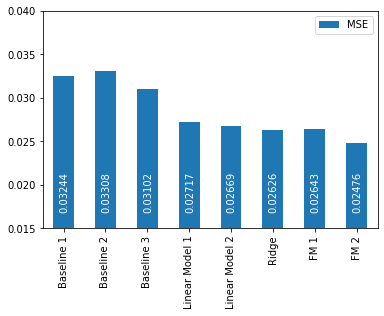

<Figure size 640x480 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# data = {'MSE': {'Baseline 1': 0.03244, 'Baseline 2': 0.03308, 'Baseline 3': 0.03102, 'Linear Model 1': 0.02717, 'Linear Model 2': 0.02669,
#                 'Ridge': 0.02626, 'FM 1': 0.02643, 'FM 2': 0.02476}}
data = pd.DataFrame({'MSE': [0.03244, 0.03308, 0.03102, 0.02717, 0.02669, 0.02626, 0.02643, 0.02476]}, 
                   index=['Baseline 1', 'Baseline 2', 'Baseline 3', 'Linear Model 1', 'Linear Model 2', 'Ridge', 'FM 1', 'FM 2'])
df = pd.DataFrame(data)

ax = df.plot.bar(ylim=(0.015, 0.040))
for p in ax.patches:
#     ax.annotate(str(p.get_height()), (p.get_x() + 0.1, p.get_height() * 0.2), color='white', rotation=90)
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, 0.017), color='white', rotation=90)
plt.figure(figsize=(8, 6), dpi=80)
plt.show()